In [1]:
!pip install -U \
    numpy pandas matplotlib seaborn \
    torch torchvision \
    tensorflow==2.16.1 tf-keras==2.16.0 \
    scikit-learn onnxruntime ultralytics \
    pillow tqdm


     -------------------------------------- 294.9/294.9 kB 6.1 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 27.2 MB/s eta 0:00:00
     ---------------------------------------- 8.9/8.9 MB 37.8 MB/s eta 0:00:00
     --------------------------------------- 13.5/13.5 MB 40.9 MB/s eta 0:00:00
     ---------------------------------------- 7.0/7.0 MB 37.4 MB/s eta 0:00:00
     -------------------------------------- 376.9/376.9 MB 1.8 MB/s eta 0:00:00
     ---------------------------------------- 5.5/5.5 MB 11.0 MB/s eta 0:00:00
     ---------------------------------------- 127.8/127.8 kB ? eta 0:00:00
     ---------------------------------------- 4.6/4.6 MB 19.8 MB/s eta 0:00:00
     ------------------------------------- 413.7/413.7 kB 13.0 MB/s eta 0:00:00
     --------------------------------------- 26.4/26.4 MB 16.0 MB/s eta 0:00:00
     ---------------------------------------- 1.4/1.4 MB 17.9 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1

ERROR: Could not install packages due to an OSError: [WinError 5] Acceso denegado: 'C:\\Users\\anays\\OneDrive\\Escritorio\\SHEFU - ENTREGABLE VC\\Completos\\Detector completos\\shefu_yolo2\\Lib\\site-packages\\~il\\_imaging.cp310-win_amd64.pyd'
Check the permissions.


[notice] A new release of pip available: 22.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [93]:
## heredar score pq las que vienen de label studio no son las 200 originales mientras que necesitamos
# que las augmentadas por roboflow tengan las mismas anotaciones
import os
import pandas as pd
from glob import glob

df = pd.read_csv(r"..\project-2-at-2025-09-12-06-46-b36c7e7f.csv")

def extract_core_name(path):
    name = os.path.basename(str(path))
    if ".rf." in name:
        name = name.split(".rf.")[0]   # quita el hash y lo que sigue
    name = os.path.splitext(name)[0]
    # eliminar prefijo tipo '4e032ea2-' al inicio
    if "-" in name:
        # quitar solo la primera parte antes del primer '-'
        parts = name.split("-", 1)
        name = parts[1] if len(parts) > 1 else parts[0]
    return name

df["core_name"] = df["data"].apply(extract_core_name)

base_dir = r"../../Detector completos/Dataset-Comida-Chilena-1"
splits = ["train", "valid", "test"]

all_images = []
for split in splits:
    for img_path in glob(os.path.join(base_dir, split, "images", "*.jpg")):
        core = os.path.basename(img_path).split(".rf.")[0]
        core = os.path.splitext(core)[0]
        all_images.append((core, split, img_path))

all_df = pd.DataFrame(all_images, columns=["core_name", "split", "img_path"])

merged = pd.merge(all_df, df, on="core_name", how="left", suffixes=("_yolo", "_annot"))

output_csv = "dataset_regresion_extendido.csv"
merged.to_csv(output_csv, index=False)


In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Dividir en train (80%), valid (10%), test (10%)
train_df, temp_df = train_test_split(merged, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(len(train_df), len(valid_df), len(test_df))


378 47 48


In [54]:
from ultralytics import YOLO
import os
from PIL import Image
import pandas as pd
import numpy as np

best_pt = r"../../Detector completos/detector_completos/rf_completos/weights/best.pt" 
yolo = YOLO(best_pt)
yolo.to("cpu")   
crop_dir = "dataset/crops"
os.makedirs(crop_dir, exist_ok=True)

def crop_one(row):
    fn = os.path.basename(str(row["img_path"])) 
    split = row["split"]
    if pd.isna(split):
        return None

    img_dir = os.path.join(base_dir, split, "images")
    src = os.path.join(img_dir, fn)
    if not os.path.exists(src):
        return None

    # Detección con YOLO
    r = yolo(src, imgsz=640, conf=0.25, verbose=False)[0]
    if r.boxes is None or len(r.boxes) == 0:
        return None

    # Bounding box más confiable
    i = int(r.boxes.conf.argmax().cpu().numpy())
    x1, y1, x2, y2 = map(int, r.boxes.xyxy[i].cpu().numpy())

    # Recorte
    im = Image.open(src).convert("RGB")
    w, h = im.size
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w, x2), min(h, y2)
    if x2 <= x1 or y2 <= y1:
        return None

    crop = im.crop((x1, y1, x2, y2))
    out_fn = f"crop_{split}_{fn}"
    out_path = os.path.join(crop_dir, out_fn)
    crop.save(out_path, quality=95)
    return out_fn

merged["crop_filename"] = merged.apply(crop_one, axis=1)

df_crops = merged.dropna(subset=["crop_filename"]).reset_index(drop=True)
df_crops.to_csv("regression_crops.csv", index=False)

print("Recortes listos:", len(df_crops), "Guardados en:", crop_dir)


Recortes listos: 455 Guardados en: dataset/crops


In [86]:

import os, ast, math, random
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

# --------------------------
# CONFIG
# --------------------------
MERGED_CSV_PATH = "dataset_regresion_extendido.csv"   
CROP_DIR        = "dataset/crops"                    
BATCH_SIZE = 16
NUM_EPOCHS = 30
LR = 1e-4
IMG_SIZE = 224
SEED = 42

# --------------------------
# Utils
# --------------------------
def set_seed(s=SEED):
    random.seed(s); np.random.seed(s)
    torch.manual_seed(s); torch.cuda.manual_seed_all(s)

def ensure_dir(d): Path(d).mkdir(parents=True, exist_ok=True)

def clean_score_cell(x):
    try:
        if isinstance(x, str):
            data = ast.literal_eval(x)
            if isinstance(data, list) and data and isinstance(data[0], dict) and "number" in data[0]:
                return float(data[0]["number"])
            return float(x)
        return float(x)
    except Exception:
        return None

# --------------------------
# 1) Cargar MERGED y preparar df_crops
# --------------------------
set_seed(); ensure_dir("checkpoints")

if not os.path.exists(MERGED_CSV_PATH):
    raise FileNotFoundError(f"No existe {MERGED_CSV_PATH}")

merged = pd.read_csv(MERGED_CSV_PATH)

# score_clean
if "score_clean" not in merged.columns:
    if "score" not in merged.columns:
        raise KeyError("El merged no tiene 'score_clean' ni 'score'.")
    merged["score_clean"] = merged["score"].apply(clean_score_cell)

# filename base si no existe
if "filename" not in merged.columns:
    if "img_path" in merged.columns:
        merged["filename"] = merged["img_path"].apply(lambda p: os.path.basename(str(p)))
    else:
        raise KeyError("El merged no tiene 'filename' ni 'img_path' ")

# crop_filename: si no viene desde el run de recorte previo, lo reconstruimos
if "crop_filename" not in merged.columns or merged["crop_filename"].isna().all():
    if "split" not in merged.columns:
        raise KeyError("Falta 'split' para reconstruir 'crop_filename'.")
    merged["crop_filename"] = merged.apply(
        lambda r: f"crop_{r['split']}_{os.path.basename(str(r['filename']))}", axis=1
    )

# filtrar filas válidas
df_crops = merged.dropna(subset=["score_clean", "crop_filename"]).reset_index(drop=True)

# chequear existencia física del recorte
df_crops["__exists__"] = df_crops["crop_filename"].apply(lambda fn: os.path.exists(os.path.join(CROP_DIR, str(fn))))
missing = (~df_crops["__exists__"]).sum()
if missing:
    print(f"{missing} crops faltan en {CROP_DIR}. Se omiten esas filas.")
    df_crops = df_crops[df_crops["__exists__"]].reset_index(drop=True)
df_crops = df_crops.drop(columns="__exists__")

print(df_crops[["crop_filename","score_clean"]].head())

# --------------------------
# 2) Dataset + Loaders
# --------------------------
class CompletoDataset(Dataset):
    def __init__(self, frame, img_dir, transform=None, fname_col="crop_filename"):
        self.df = frame.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.fname_col = fname_col
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row[self.fname_col])
        with Image.open(img_path).convert("RGB") as image:
            if self.transform: image = self.transform(image)
        score = float(row["score_clean"]) / 100.0
        return image, torch.tensor([score], dtype=torch.float32)

train_df, temp_df = train_test_split(df_crops, test_size=0.2, random_state=SEED)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED)

weights = MobileNet_V3_Small_Weights.IMAGENET1K_V1
_mean, _std = weights.transforms().mean, weights.transforms().std

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=_mean, std=_std),
])
valid_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=_mean, std=_std),
])

train_loader = DataLoader(CompletoDataset(train_df, CROP_DIR, train_tfms), BATCH_SIZE, True,  num_workers=0)
valid_loader = DataLoader(CompletoDataset(valid_df, CROP_DIR, valid_tfms), BATCH_SIZE, False, num_workers=0)
test_loader  = DataLoader(CompletoDataset(test_df,  CROP_DIR, valid_tfms), BATCH_SIZE, False, num_workers=0)

print(f"Split: {len(train_df)} train | {len(valid_df)} valid | {len(test_df)} test")

# --------------------------
# 3) Modelo
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = mobilenet_v3_small(weights=weights)
in_f = model.classifier[3].in_features
model.classifier[3] = nn.Sequential(nn.Linear(in_f, 1), nn.Sigmoid())
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

# --------------------------
# 4) Train + Early stopping
# --------------------------
best_val = math.inf
patience, counter = 5, 0
ensure_dir("checkpoints")

history = {"train_loss": [], "val_loss": []}


for epoch in range(NUM_EPOCHS):
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    model.train(); tr_loss = 0.0
    for imgs, scores in train_loader:
        imgs, scores = imgs.to(device), scores.to(device)
        preds = model(imgs)
        loss = criterion(preds, scores)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        tr_loss += loss.item() * imgs.size(0)
    tr_loss /= len(train_loader.dataset)

    model.eval(); va_loss = 0.0
    with torch.no_grad():
        for imgs, scores in valid_loader:
            imgs, scores = imgs.to(device), scores.to(device)
            preds = model(imgs); loss = criterion(preds, scores)
            va_loss += loss.item() * imgs.size(0)
    va_loss /= len(valid_loader.dataset)

    print(f"Epoch {epoch+1:02d}/{NUM_EPOCHS} | Train {tr_loss:.4f} | Val {va_loss:.4f}")

    if va_loss < best_val - 1e-4:
        best_val = va_loss; counter = 0
        torch.save(model.state_dict(), "checkpoints/best_model.pth")
        print("Mejor modelo actualizado")
    else:
        counter += 1
        print(f"Sin mejora ({counter}/{patience})")
        if counter >= patience:
            print("Early stopping")
            break

print("Entrenamiento terminado. Mejor modelo: checkpoints/best_model.pth")

# --------------------------
# 5) Evaluación
# --------------------------
model.eval(); y_true, y_pred = [], []
with torch.no_grad():
    for imgs, scores in test_loader:
        imgs = imgs.to(device)
        preds = model(imgs).cpu().numpy().flatten()
        y_pred.extend(preds * 100.0)
        y_true.extend(scores.numpy().flatten() * 100.0)

y_true, y_pred = np.array(y_true), np.array(y_pred)
mae  = float(np.mean(np.abs(y_true - y_pred))) if len(y_true) else float("nan")
rmse = float(np.sqrt(np.mean((y_true - y_pred)**2))) if len(y_true) else float("nan")
print(f"Test MAE: {mae:.2f} | RMSE: {rmse:.2f} (0–100)")


12 crops faltan en dataset/crops. Se omiten esas filas.
Dataset listo: 454 filas
                                       crop_filename  score_clean
0  crop_train_112_jpg.rf.1f0aa54d9b7400df7d6795bc...        100.0
1  crop_train_112_jpg.rf.3b0773602c561facfed10e99...        100.0
2  crop_train_112_jpg.rf.4b78c84562d5751fffa3104b...        100.0
3  crop_train_11_jpg.rf.1d6a02483ef8f6bbd92937155...         80.0
4  crop_train_11_jpg.rf.bc216dc89f4f31f87b3cd5d6f...         80.0
Split: 363 train | 45 valid | 46 test
Device: cpu
Epoch 01/30 | Train 0.0517 | Val 0.0675
Mejor modelo actualizado
Epoch 02/30 | Train 0.0425 | Val 0.0576
Mejor modelo actualizado
Epoch 03/30 | Train 0.0330 | Val 0.0486
Mejor modelo actualizado
Epoch 04/30 | Train 0.0245 | Val 0.0449
Mejor modelo actualizado
Epoch 05/30 | Train 0.0222 | Val 0.0409
Mejor modelo actualizado
Epoch 06/30 | Train 0.0183 | Val 0.0319
Mejor modelo actualizado
Epoch 07/30 | Train 0.0177 | Val 0.0261
Mejor modelo actualizado
Epoch 08/30 | Trai

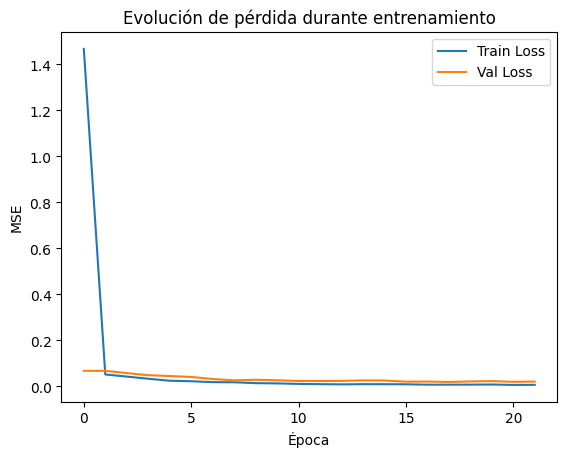

In [87]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Época")
plt.ylabel("MSE")
plt.legend()
plt.title("Evolución de pérdida durante entrenamiento")
plt.savefig("checkpoints/training_curve.png", dpi=150)
plt.show()


In [88]:
import matplotlib.pyplot as plt
import numpy as np

# Cargar mejor modelo
model.load_state_dict(torch.load("checkpoints/best_model.pth", map_location=device))
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for imgs, scores in test_loader:
        imgs, scores = imgs.to(device), scores.to(device)
        preds = model(imgs).cpu().numpy().flatten()
        scores = scores.cpu().numpy().flatten()

        # volver a escala 0–100
        y_pred.extend(preds * 100)
        y_true.extend(scores * 100)

y_true, y_pred = np.array(y_true), np.array(y_pred)

# Métricas
mae = np.mean(np.abs(y_true - y_pred))
rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

print(f"MAE: {mae:.2f} puntos | RMSE: {rmse:.2f} puntos")


MAE: 11.51 puntos | RMSE: 15.40 puntos


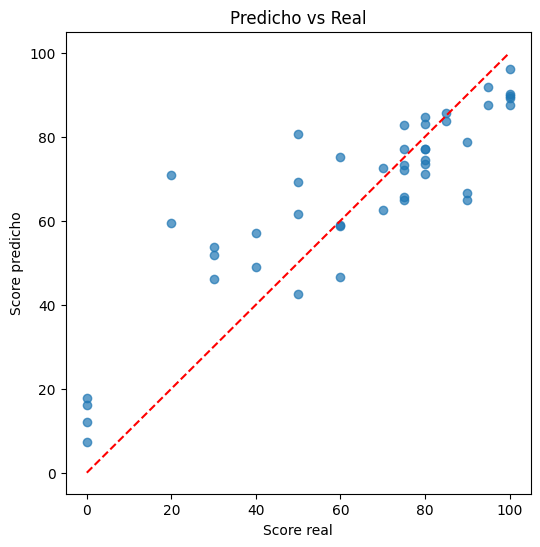

In [89]:
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.7)
plt.plot([0,100], [0,100], 'r--')  # línea ideal
plt.xlabel("Score real")
plt.ylabel("Score predicho")
plt.title("Predicho vs Real")
plt.show()


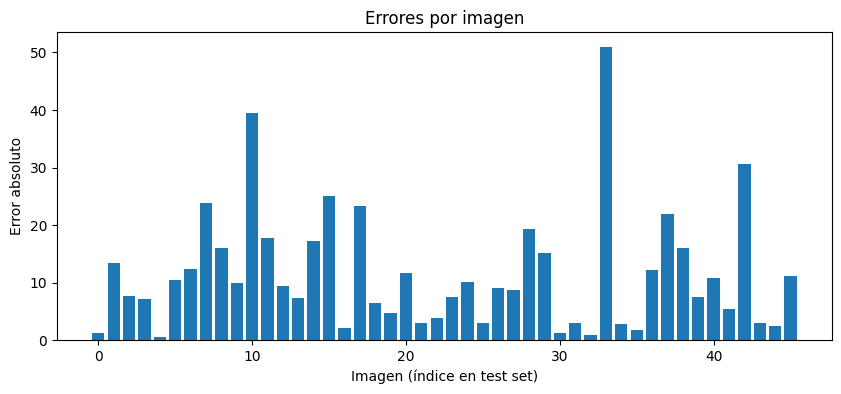

In [90]:
errors = np.abs(y_true - y_pred)

plt.figure(figsize=(10,4))
plt.bar(range(len(errors)), errors)
plt.xlabel("Imagen (índice en test set)")
plt.ylabel("Error absoluto")
plt.title("Errores por imagen")
plt.show()


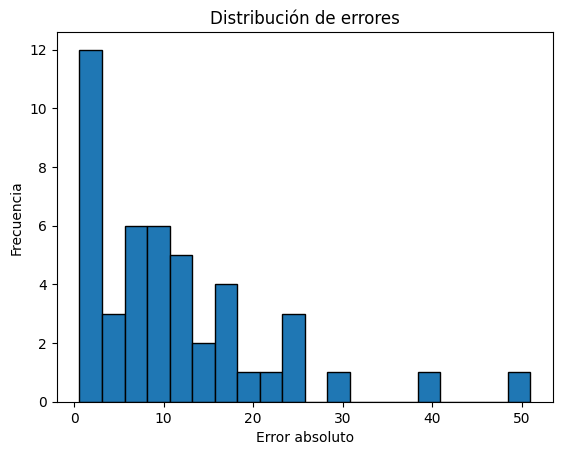

In [91]:
plt.hist(errors, bins=20, edgecolor="black")
plt.xlabel("Error absoluto")
plt.ylabel("Frecuencia")
plt.title("Distribución de errores")
plt.show()


Resultados guardados en checkpoints/test_results.csv (46 filas)
Test MAE: 11.51 | RMSE: 15.40 (escala 0–100)


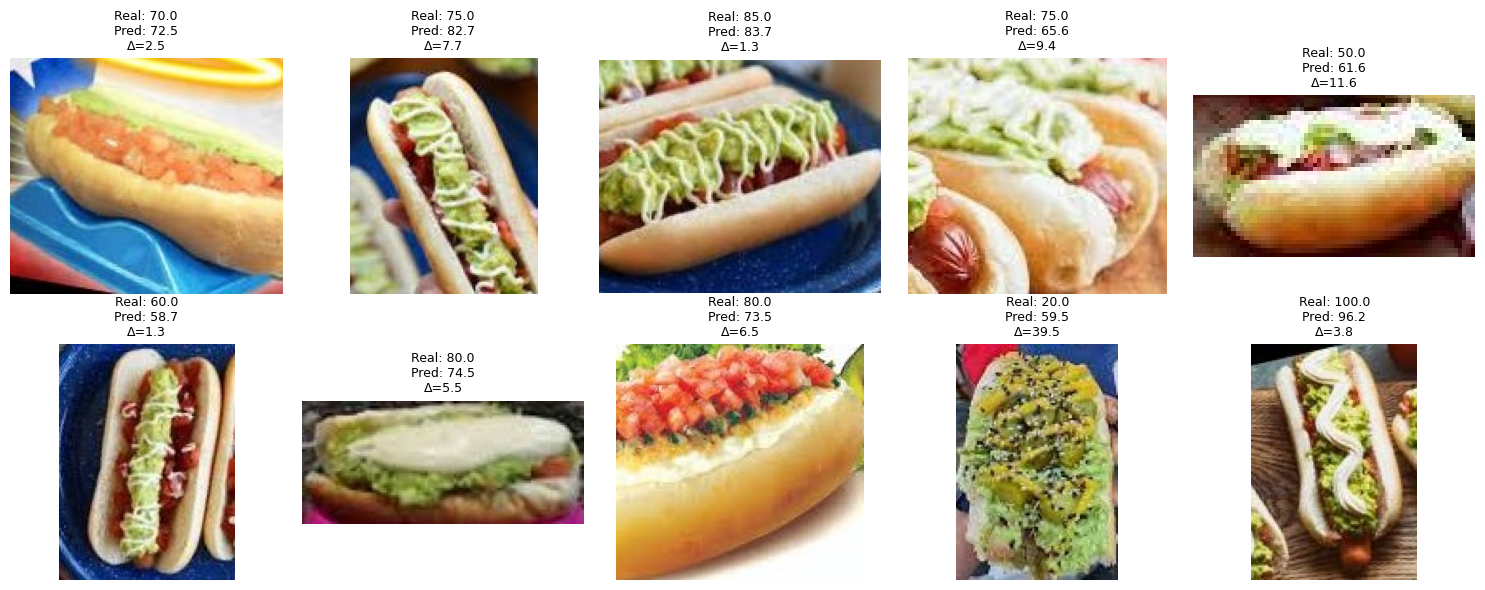

In [95]:
# =========================================================
# 5) EVALUACIÓN + VISUALIZACIÓN CORRECTA
# =========================================================
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

model.eval()

results = []  # lista para guardar predicciones y rutas

# 🔹 Evaluación con tracking de archivos
with torch.no_grad():
    for i, (imgs, scores) in enumerate(test_loader):
        preds = model(imgs.to(device)).cpu().numpy().flatten() * 100
        reals = scores.numpy().flatten() * 100
        batch_size = len(preds)

        # Obtener el subset correspondiente de test_df
        start_idx = i * test_loader.batch_size
        end_idx = start_idx + batch_size
        sub_df = test_df.iloc[start_idx:end_idx]

        for j, row in enumerate(sub_df.itertuples()):
            results.append({
                "img_path": os.path.join(CROP_DIR, row.crop_filename),
                "real": float(reals[j]),
                "pred": float(preds[j]),
                "core_name": getattr(row, "core_name", "NA")
            })

# 🔹 Convertir resultados a DataFrame
results_df = pd.DataFrame(results)
results_df["error_abs"] = abs(results_df["real"] - results_df["pred"])
results_df.to_csv("checkpoints/test_results.csv", index=False)
print(f"Resultados guardados en checkpoints/test_results.csv ({len(results_df)} filas)")

# 🔹 Métricas globales
mae  = results_df["error_abs"].mean()
rmse = math.sqrt(((results_df["real"] - results_df["pred"]) ** 2).mean())
print(f"Test MAE: {mae:.2f} | RMSE: {rmse:.2f} (escala 0–100)")

# =========================================================
# 6) VISUALIZACIÓN: predicciones vs reales (aleatorias)
# =========================================================
n = 10
cols = 5
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
axes = axes.flatten()

# Elegir 10 imágenes aleatorias del test set
subset = results_df.sample(n=n, random_state=None)

for i, row in enumerate(subset.itertuples()):
    img = Image.open(row.img_path)
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Real: {row.real:.1f}\nPred: {row.pred:.1f}\nΔ={row.error_abs:.1f}", fontsize=9)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


In [97]:
import numpy as np

def evaluate_mae(model, dataloader, device):
    """Evalúa MAE sobre un DataLoader."""
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, scores in dataloader:
            imgs, scores = imgs.to(device), scores.to(device)
            preds = model(imgs).cpu().numpy().flatten()
            y_pred.extend(preds * 100.0)
            y_true.extend(scores.cpu().numpy().flatten() * 100.0)
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

# Calcular MAE para cada split
train_mae = evaluate_mae(model, train_loader, device)
val_mae   = evaluate_mae(model, valid_loader, device)
test_mae  = evaluate_mae(model, test_loader, device)

print(f"Train MAE: {train_mae:.2f}")
print(f"Val   MAE: {val_mae:.2f}")
print(f"Test  MAE: {test_mae:.2f}")


Train MAE: 4.74
Val   MAE: 10.46
Test  MAE: 11.51


In [ ]:
import torch

from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
import torch.nn as nn

weights = MobileNet_V3_Small_Weights.IMAGENET1K_V1
model = mobilenet_v3_small(weights=weights)
in_f = model.classifier[3].in_features
model.classifier[3] = nn.Sequential(
    nn.Linear(in_f, 1),
    nn.Sigmoid()
)

model.load_state_dict(torch.load("checkpoints/best_model.pth", map_location="cpu"))
model.eval()

# Dummy input (batch_size=1, 3 canales, 224x224)
dummy_input = torch.randn(1, 3, 224, 224)

# Exportar a ONNX
torch.onnx.export(
    model,
    dummy_input,
    "completos_model.onnx",
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch"}, "output": {0: "batch"}},
    opset_version=13
)
print("Exportado a ONNX: completos_model.onnx")


AttributeError: cannot import name 'float4_e2m1fn' from 'ml_dtypes'

In [ ]:
import onnxruntime as ort
import numpy as np

ort_session = ort.InferenceSession("completos_model.onnx")
dummy = np.random.randn(1, 3, 224, 224).astype(np.float32)
outputs = ort_session.run(None, {"input": dummy})
print("ONNX output:", outputs[0])


ONNX output: [[    0.49433]]


In [ ]:
import os
print("Existe:", os.path.exists("completos_model.onnx"))
print("Tamaño (bytes):", os.path.getsize("completos_model.onnx"))
import subprocess, sys

cmd = [sys.executable, "-m", "onnx2tf",
    "-i", "completos_model.onnx",
    "-o", "shefu_tf",
    "--disable_ai_edge_litert",
    "--non_verbose"]
result = subprocess.run(cmd, capture_output=True, text=True)
print("STDOUT:\n", result.stdout)
print("STDERR:\n", result.stderr)



Existe: True
Tamaño (bytes): 6090104
🔴 STDOUT:
 
🔴 STDERR:
 Traceback (most recent call last):
  File "c:\Users\anays\OneDrive\Escritorio\shefu_vc\shefu\yolov8\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 70, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: %1 no es una aplicaciÃ³n Win32 vÃ¡lida.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\anays\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 187, in _run_module_as_main
    mod_name, mod_spec, code = _get_module_details(mod_name, _Error)
  File "C:\Users\anays\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 146, in _get_module_details
    return _get_module_details(pkg_main_name, error)
  File "C:\Users\anays\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 110, in _get_module_details
    __import__(pkg_nam

In [ ]:

import os, sys, subprocess, tensorflow as tf

onnx_path = "completos_model.onnx"
tf_dir = "shefu_tf"
tflite_path = "completos_model.tflite"

print("Verificando dependencias...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "onnx2tf", "onnx_graphsurgeon"])

print(f"Convirtiendo {onnx_path} → {tf_dir}/ ...")

cmd = [
    sys.executable, "-m", "onnx2tf",
    "-i", "completos_model.onnx",
    "-o", "shefu_tf",
    "--disable_ai_edge_litert",
    "--non_verbose"
]
subprocess.run(cmd, check=True)

print(" Exportando a TFLite...")
converter = tf.lite.TFLiteConverter.from_saved_model(tf_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open(tflite_path, "wb") as f:
    f.write(tflite_model)

print(f" Conversión completa: {tflite_path}")


Verificando dependencias...
Convirtiendo completos_model.onnx → shefu_tf/ ...


CalledProcessError: Command '['c:\\Users\\anays\\OneDrive\\Escritorio\\shefu_vc\\shefu\\yolov8\\Scripts\\python.exe', '-m', 'onnx2tf', '-i', 'completos_model.onnx', '-o', 'shefu_tf', '--disable_ai_edge_litert', '--non_verbose']' returned non-zero exit status 1.

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model("shefu_tf")
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Opcional: reducir tamaño
tflite_model = converter.convert()

with open("shefu_model.tflite", "wb") as f:
    f.write(tflite_model)

print(" Modelo TFLite guardado en shefu_model.tflite")


OSError: SavedModel file does not exist at: shefu_tf\{saved_model.pbtxt|saved_model.pb}